# AstroPrism Tutorial: Posterior Analysis

After running variational inference, we have samples from the approximate posterior $q(\theta) \approx p(\theta | d)$. This tutorial covers:

- **Loading saved results** from the inference output directory
- **Visualizing posterior samples** of the reconstructed sky signal
- **Parameter estimates** with uncertainties (mean ± std)
- **Residual analysis** comparing model predictions to observed data
- **Convergence diagnostics** to assess inference quality


## Imports

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import warnings
from astropy.utils.exceptions import AstropyWarning
import jax
import pickle
import nifty8.re as jft
import jax.numpy as jnp

warnings.filterwarnings('ignore', category=AstropyWarning)

## Demonstration

In [2]:
# Load Dataset
from astroprism.io import load_dataset, SingleInstrumentDataset
path = "../data/tutorial/jwst_miri_cutout/"
dataset = load_dataset(path=path, instrument="JWST_MIRI", extension="fits")
print(dataset.summary())

# GP Sky Model
from astroprism.models.gp import SpatialGP, MixtureGP
spatial_gp = SpatialGP(
    n_channels=len(dataset),
    shape=dataset.shapes[0],
    distances=dataset.pixel_scales[0],
)
mixture = MixtureGP(spatial_gps=spatial_gp)

# Instrument Response Model
from astroprism.models.response import InstrumentResponse
response = InstrumentResponse(
    dataset=dataset,
    signal_wcs=dataset.wcs[0],
    signal_shape=dataset.shapes[0],
)

# Noise Model
from astroprism.models.noise import NoiseModel
noise = NoiseModel(n_channels=len(dataset))

# Forward Model
from astroprism.models.forward import ForwardModel
model = ForwardModel(mixture, response, noise)
print("ForwardModel domain keys:", list(model.domain.keys()))

SingleInstrumentDataset Summary:
--------------------------------
Number of channels: 4
Channel keys: ['F1000W_full', 'F1130W_full', 'F2100W_full', 'F770W_full']
Channel shapes: [(600, 600), (600, 600), (600, 600), (600, 600)]
Pixel scales: [(0.11091449975820492, 0.1109144997630491), (0.11091449949791077, 0.11091449946799463), (0.11091449907273217, 0.11091449905375952), (0.11091450012231652, 0.11091450010349585)]

ForwardModel domain keys: ['zeromode', 'fluctuations', 'loglogavgslope', 'spectrum', 'flexibility', 'xi', 'mixture_matrix', 'mixing_offset', 'psf_sigma', 'psf_rotation', 'background_std', 'poisson_scale']


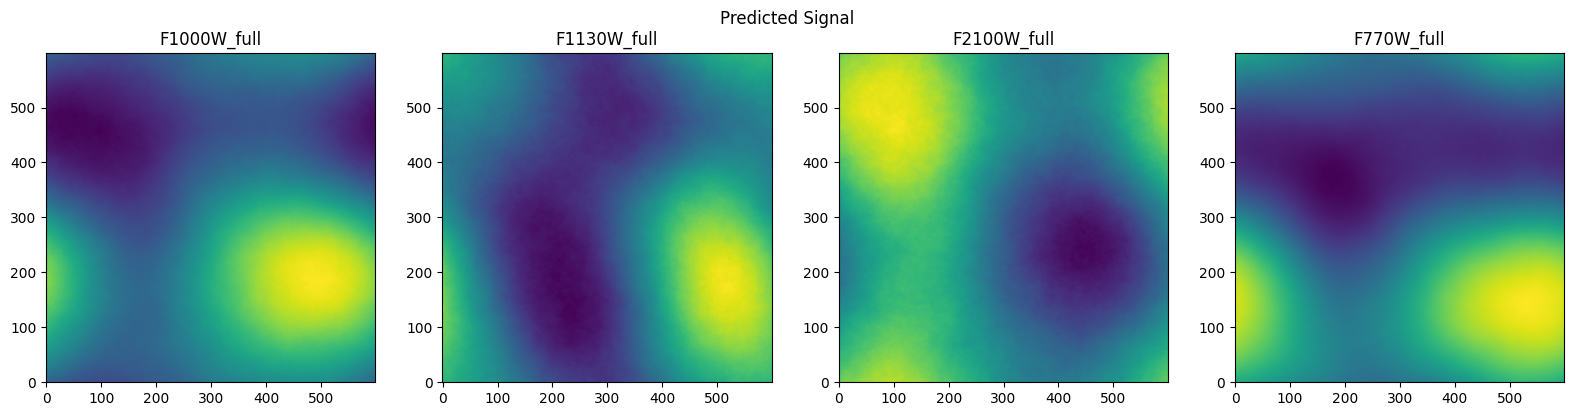

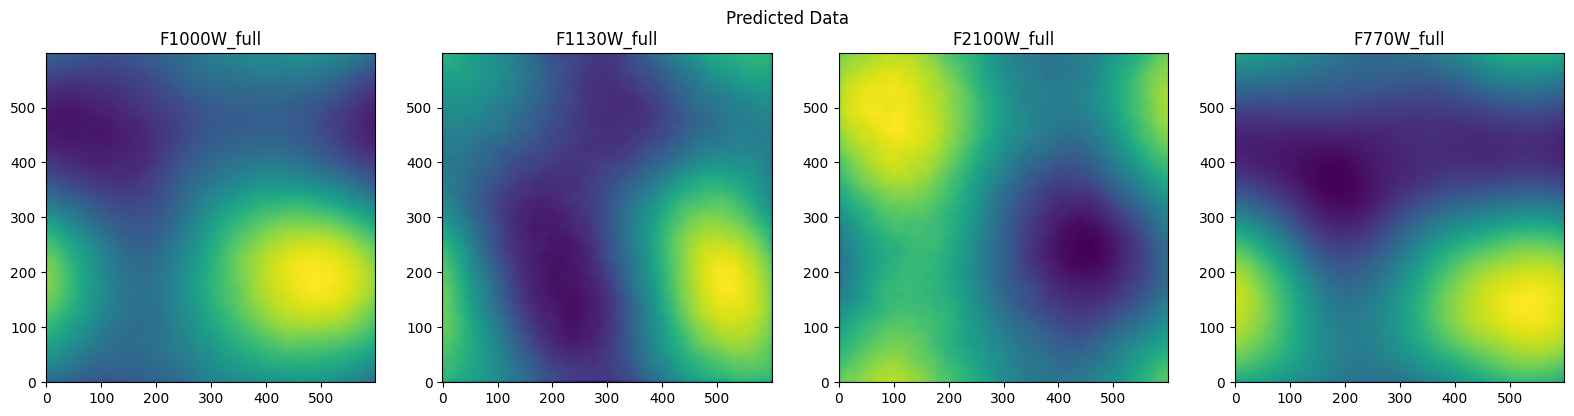

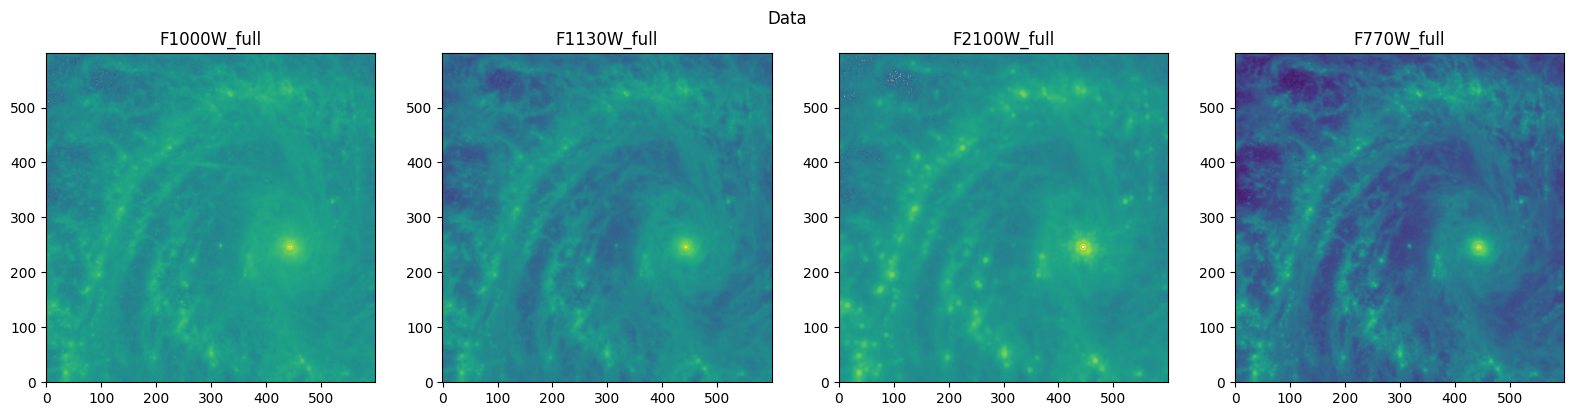

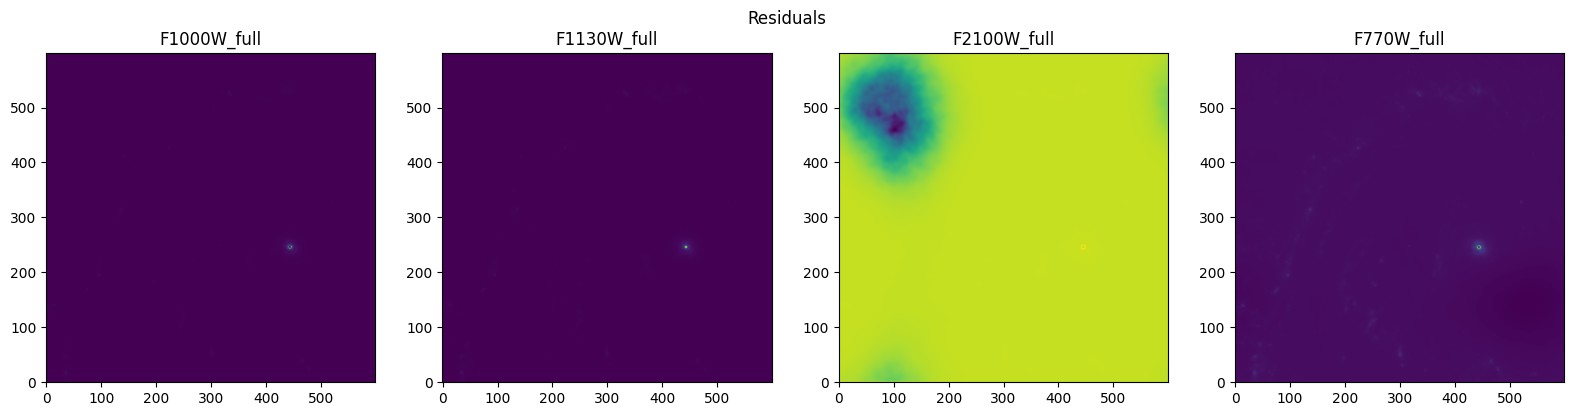

In [3]:
# Load inference results first to check what was saved
results_dir = Path("tutorial_results")
samples, state = pickle.load(open(results_dir / "last.pkl", "rb"))

# Posterior Mean
posterior_means = jft.mean(samples)

# Predicted signal
pred_signal_mean = mixture(posterior_means)

# Predicted data
pred_data_mean = response(posterior_means, pred_signal_mean)

# Residuals
residuals = jnp.array(dataset.data) - jnp.array(pred_data_mean)

# Plot Predicted Signal
fig, axes = plt.subplots(1, dataset.n_channels, figsize=(4*dataset.n_channels, 4))
for i in range(dataset.n_channels):
    axes[i].imshow(pred_signal_mean[i], origin='lower', norm=LogNorm())
    axes[i].set_title(dataset.channel_keys[i])
plt.suptitle("Predicted Signal")
plt.tight_layout()

# Plot Predicted Data
fig, axes = plt.subplots(1, dataset.n_channels, figsize=(4*dataset.n_channels, 4))
for i in range(dataset.n_channels):
    axes[i].imshow(pred_data_mean[i], origin='lower', norm=LogNorm())
    axes[i].set_title(dataset.channel_keys[i])
plt.suptitle("Predicted Data")
plt.tight_layout()

# Plot Actual Data
fig, axes = plt.subplots(1, dataset.n_channels, figsize=(4*dataset.n_channels, 4))
for i, key in enumerate(dataset.channel_keys):
    data, wcs, psf = dataset[key]
    axes[i].imshow(data, norm=LogNorm(), origin='lower')
    axes[i].set_title(key)
plt.suptitle("Data")
plt.tight_layout()
plt.show()

# Plot Residuals
fig, axes = plt.subplots(1, dataset.n_channels, figsize=(4*dataset.n_channels, 4))
for i in range(dataset.n_channels):
    axes[i].imshow(residuals[i], origin='lower')
    axes[i].set_title(dataset.channel_keys[i])
plt.suptitle("Residuals")
plt.tight_layout()
